In [1]:
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
# set up fields
TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)
# make splits for data
# DO NOT MODIFY: fine_grained=True, train_subtrees=False
train, val, test = datasets.SST.splits(
    TEXT, LABEL, fine_grained=True, train_subtrees=False)

In [3]:
# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))

train.fields {'text': <torchtext.data.field.Field object at 0x000002DC82634708>, 'label': <torchtext.data.field.Field object at 0x000002DC826346C8>}
len(train) 8544
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}


In [4]:
# build the vocabulary
# you can use other pretrained vectors, refer to https://github.com/pytorch/text/blob/master/torchtext/vocab.py
TEXT.build_vocab(train, vectors=Vectors(name='vector.txt', cache='./data'))
LABEL.build_vocab(train)
# We can also see the vocabulary directly using either the stoi (string to int) or itos (int to string) method.
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)
print(TEXT.vocab.freqs.most_common(20))

['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000002DC86484F08>>, {'<unk>': 0, 'positive': 1, 'negative': 2, 'neutral': 3, 'very positive': 4, 'very negative': 5})
[('.', 8024), (',', 7131), ('the', 6037), ('and', 4431), ('a', 4403), ('of', 4386), ('to', 2995), ("'s", 2544), ('is', 2536), ('that', 1915), ('in', 1789), ('it', 1775), ('The', 1265), ('as', 1200), ('film', 1152), ('but', 1076), ('with', 1071), ('for', 963), ('movie', 959), ('its', 912)]


In [5]:
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

len(TEXT.vocab) 18282
TEXT.vocab.vectors.size() torch.Size([18282, 300])


In [6]:
# make iterator for splits
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=64)

In [7]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([18282, 300])


In [8]:
class Double_Dropout_BiLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(Double_Dropout_BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True, dropout = 0.5, num_layers = 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, sentence):
        embedded_text = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embedded_text)
        return self.fc(lstm_out[-1])

In [9]:
model = Double_Dropout_BiLSTM(len(TEXT.vocab), pretrained_embeddings.shape[1], 256, 5)
model.word_embeddings.weight.data.copy_(pretrained_embeddings)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [10]:
device = torch.device("cpu") ## change to CUDA
model = model.to(device)
loss_function = loss_function.to(device)
train_loss, train_acc, val_loss, val_acc = [], [], [], []


In [11]:
iter = 0
for epoch in range(30):
    model.train()
    for batch in train_iter:
        #batch = next(iter(train_iter))
        iter+=1
        targets = batch.label.to(device)
        targets = targets.sub(1)
        X = batch.text.to(device)
        optimizer.zero_grad()
        tag_scores = model(X)
        tag_scores = tag_scores.squeeze(1)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        
        _, predicted = torch.max(tag_scores, 1)
        correct = (predicted == targets).float()
        batch_acc = correct.sum() / len(correct)
        
        optimizer.step()
        
        train_acc.append(batch_acc.item())
        train_loss.append(loss.item() / len(train_iter))
        
        if iter % 30 == 0:
            print("Last 30 batches accuracy: {:.3f}".format(np.mean(train_acc[-30:])))
        
    print("Epoch ", epoch, ", train accuracy: {:.3f}".format(np.mean(train_acc[-len(train_iter):])))
    
    model.eval()
    with torch.no_grad():
        for batch in val_iter:
            targets = batch.label.to(device)
            targets = targets.sub(1)
            tag_scores = model(batch.text.to(device))
            tag_scores = tag_scores.squeeze(1)
            loss = loss_function(tag_scores, targets)
            _, predicted = torch.max(tag_scores, 1)
            correct = (predicted == targets).float()
            batch_acc = correct.sum() / len(correct)
            val_acc.append(batch_acc.item())
            val_loss.append(loss.item() / len(val_iter))
    
    print("Epoch ", epoch, ", validation accuracy: {:.3f}".format(np.mean(val_acc[-len(val_iter):])))



test_acc = []
test_loss = []
model.eval()
with torch.no_grad():
    for batch in test_iter:
        targets = batch.label.to(device)
        targets = targets.sub(1)
        tag_scores = model(batch.text.to(device))
        tag_scores = tag_scores.squeeze(1)
        loss = loss_function(tag_scores, targets)
        _, predicted = torch.max(tag_scores, 1)
        correct = (predicted == targets).float()
        batch_acc = correct.sum() / len(correct)
        test_acc.append(batch_acc.item())
        test_loss.append(loss.item())
    
print("Test accuracy:  {:.3f}".format(np.mean(test_acc)))
        
        
        
        
    
    

Last 30 batches accuracy: 0.260
Last 30 batches accuracy: 0.260
Last 30 batches accuracy: 0.270
Last 30 batches accuracy: 0.272
Epoch  0 , train accuracy: 0.265
Epoch  0 , validation accuracy: 0.252
Last 30 batches accuracy: 0.257
Last 30 batches accuracy: 0.265
Last 30 batches accuracy: 0.263
Last 30 batches accuracy: 0.271
Epoch  1 , train accuracy: 0.266
Epoch  1 , validation accuracy: 0.312
Last 30 batches accuracy: 0.274
Last 30 batches accuracy: 0.274
Last 30 batches accuracy: 0.268
Last 30 batches accuracy: 0.272
Last 30 batches accuracy: 0.325
Epoch  2 , train accuracy: 0.289
Epoch  2 , validation accuracy: 0.291
Last 30 batches accuracy: 0.290
Last 30 batches accuracy: 0.271
Last 30 batches accuracy: 0.273
Last 30 batches accuracy: 0.274
Epoch  3 , train accuracy: 0.269
Epoch  3 , validation accuracy: 0.310
Last 30 batches accuracy: 0.261
Last 30 batches accuracy: 0.266
Last 30 batches accuracy: 0.273
Last 30 batches accuracy: 0.249
Last 30 batches accuracy: 0.276
Epoch  4 , t

Text(0.5, 1.0, 'Train loss')

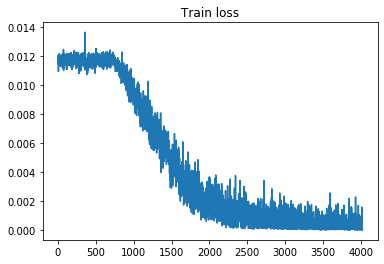

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title('Train loss')

Text(0.5, 1.0, 'Train accuracy')

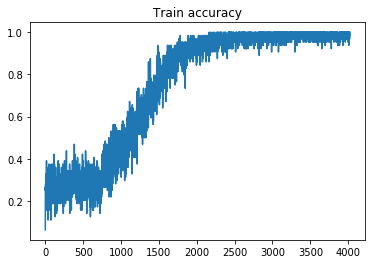

In [13]:
plt.plot(train_acc)
plt.title('Train accuracy')

Text(0.5, 1.0, 'Validation loss')

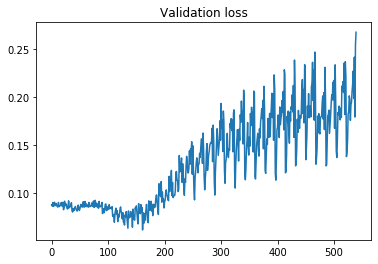

In [14]:
plt.plot(val_loss)
plt.title('Validation loss')

Text(0.5, 1.0, 'Validation accuracy')

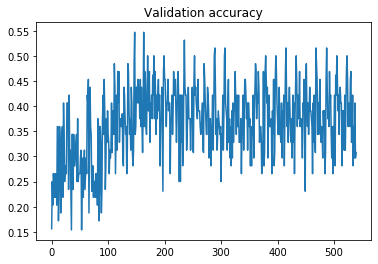

In [15]:
plt.plot(val_acc)
plt.title('Validation accuracy')

In [16]:
print("Test loss:  {:.3f}".format(np.mean(test_loss)))

Test loss:  3.288
